# Introduction

### Competition Objective

*In this competition, you’re challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. Hopefully, the outcome will be more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data.*

This is exploritory data analysis for the Google Analytics Customer Revenue Prediction Competion on Kaggle. The competition ended on November 30th 2018 and the results are evaluated on future data compiled between December 1st 2018 to January 31st 2019.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from datetime import datetime

import json
import os

import matplotlib.pyplot as plt
import seaborn as sns

from plotly import tools
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.offline as py
import plotly.graph_objs as go

# About in the Data

### Data Fields

**fullVisitorId** - A unique identifier for each user of the Google Merchandise Store.

**channelGrouping** - The channel via which the user came to the Store.

**date** - The date on which the user visited the Store.

**device** - The specifications for the device used to access the Store. (JSON format)

**geoNetwork** - This section contains information about the geography of the user. (JSON format)

**socialEngagementType** - Engagement type, either "Socially Engaged" or "Not Socially Engaged".

**totals** - This section contains aggregate values across the session. (JSON format)

**trafficSource** - This section contains information about the Traffic Source from which the session originated. (JSON format)

**visitId** - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.

**visitNumber** - The session number for this user. If this is the first session, then this is set to 1.

**visitStartTime** - The timestamp (expressed as POSIX time).

**hits** - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.

**customDimensions** - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.

**totals** - This set of columns mostly includes high-level aggregate data.


### Timeframe

The training data we are using is from August 2016 to May 2018.

### Size and Format

The version 2 of the training data is fairly large at ~1.7 million rows. While in a csv file, many of the columns are in JSON format. 

# Read in the Data

The 1.7 million rows will need to be read in chunks of 100K to not overload memory. **customDimensions** and **hits** columns are extremely large and don't help much in an EDA so they are dropped to save space.  The JSON format columns need to also be processed into additional columns. This block takes around 8 minutes to complete.

In [2]:
%%time

def load_df(csv_path='../input/train_v2.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.DataFrame([])
    for chunk in pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'},
                     chunksize=nrows):

        chunk = chunk.drop(['customDimensions','hits'], axis=1)
        df = df.append(chunk, ignore_index=True)
        print(df.shape[0])
    print("Dataframe assembled; Working on JSON columns...")
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print("Done!")
    return df

train = load_df('../input/train_v2.csv', 100000)
train["totals.transactionRevenue"] = train["totals.transactionRevenue"].astype('float')

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1708337
Dataframe assembled; Working on JSON columns...
Done!
CPU times: user 8min 10s, sys: 42.1 s, total: 8min 52s
Wall time: 8min 53s


# First Impressions

In [3]:
print("Colunms in dataset: " + str(train.shape[1]))
print("Rows in dataset: " + str(train.shape[0]))
train[:10]

Colunms in dataset: 58
Rows in dataset: 1708337


,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,Western Europe,1,1,1,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,water bottle,organic,NaN,google
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset,Cupertino,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,NaN,2,NaN,2,2,28,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,not available in demo dataset,not available in demo dataset,Northern America,NaN,2,1,2,1,38,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,True,NaN,(none),NaN,(direct)
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,150816

## First Impressions: What We Learned

- Separating out the JSON columns balloons the columns up to 58. A lot of these will be useful, but many will not.

- Many columns seem full of NaN values and many others have almost NaN equivalent strings like "not available in demo dataset" and "(not set)"


# Looking at Na/Unique Values

In [4]:
na_counts = pd.DataFrame(train.isnull().sum())
na_counts.columns = ['na_counts']
na_counts['%na'] = round(na_counts['na_counts'] / train.shape[0], 4) * 100
uniq_counts = pd.DataFrame(train.nunique(dropna=False))
uniq_counts.columns = ['uniq_counts']
na_uniq_counts = na_counts.join(uniq_counts, how='outer').sort_values(by='na_counts', ascending=False)

print("There are "+str(len(na_uniq_counts.loc[na_uniq_counts["na_counts"] > 0]))+" columns with na values")
const_cols = [c for c in train.columns if train[c].nunique(dropna=False)==1 ]
print("There are "+str(len(const_cols))+" colunms with only one unique value")

na_uniq_counts
# train = train.drop(const_cols, axis=1)

There are 18 columns with na values
There are 19 colunms with only one unique value


,na_counts,%na,uniq_counts
trafficSource.campaignCode,1708336,100.00,2
totals.totalTransactionRevenue,1689823,98.92,8507
totals.transactionRevenue,1689823,98.92,7252
totals.transactions,1689778,98.91,14
trafficSource.adContent,1643600,96.21,77
trafficSource.adwordsClickInfo.page,1633063,95.59,12
trafficSource.adwordsClickInfo.adNetworkType,1633063,95.59,4
trafficSource.adwordsClickInfo.isVideoAd,1633063,95.59,2
trafficSource.adwordsClickInfo.slot,1633063,95.59,4
trafficSource.adwordsClickInfo.gclId,1632914,95.59,59009


## Looking at Na/Unique Values: What We Learned

- There are 19 columns with only one unique value. These are worthless for data prediction and can be dropped immediatly. Some of these are due to the demo version of google analytics so might have value with the full version.

- 18 columns have na values. Of these 10 are more than 95% na values.

# Transaction Revenue: Exploration

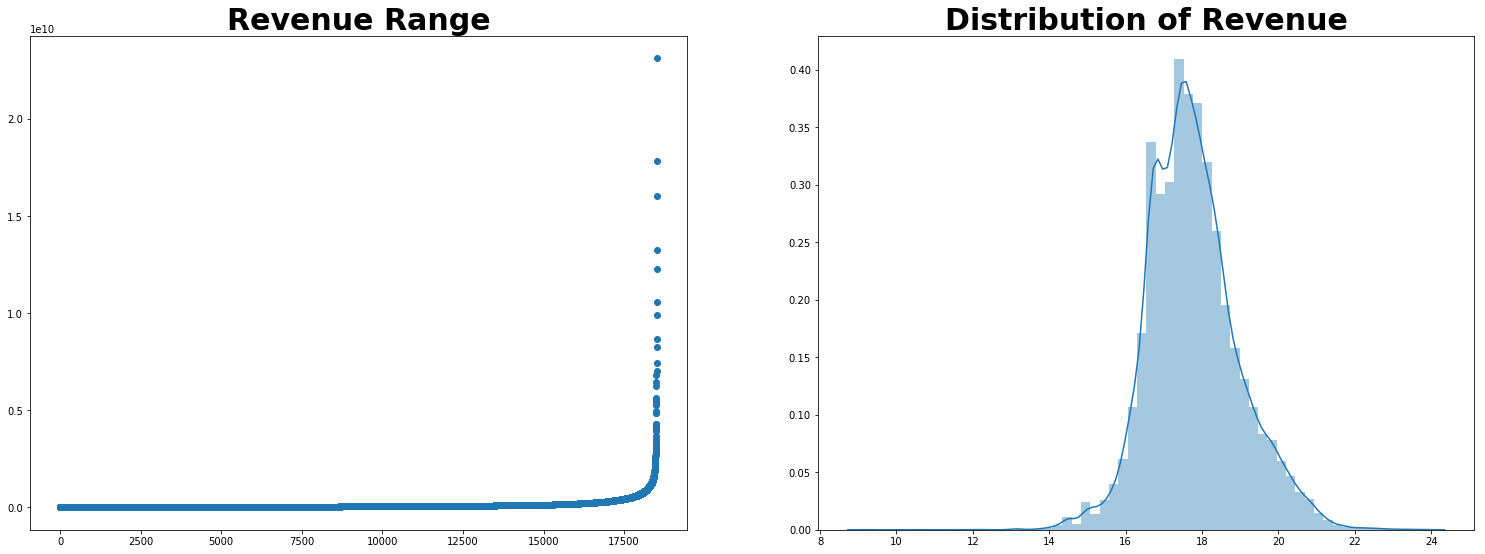

In [5]:
plt.figure(figsize=[40,20])

fontdict = {'fontsize': 30, 'fontweight' : 'bold'}

plt.subplot(231)
plt.scatter(range(train.shape[0]), np.sort(train['totals.transactionRevenue'].values))
plt.title("Revenue Range", fontdict=fontdict)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(232)
sns.distplot( np.log(train[train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"]), bins=60, kde=True)
plt.title("Distribution of Revenue", fontdict=fontdict)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('')
plt.ylabel('')
plt.show()

## Transaction Revenue: What We Learned

- The vast majority of visits had no revenue. In other words, no items were purchased during those visits.

- The distribution of revenue looks normally distributed.


# Visitors: Exploration

In [6]:
print("In the dataset of "+str(train.shape[0])+" visits there are...")
print("Number of unique visitors: "+str(train["fullVisitorId"].nunique()))
print("Presentage of visits that bought something: %"+str(train.loc[train["totals.transactionRevenue"] > 0].shape[0]/train.shape[0]*100))

train_first_visit = train.loc[train["visitNumber"] == 1]
print("Percentage of visits that were for the first time: %"+str(train_first_visit.shape[0]/train.shape[0]*100))
print("Presentage of first time visitors that bought something: %"+str(train_first_visit.loc[train_first_visit["totals.transactionRevenue"] > 0].shape[0]/train.shape[0]*100))

In the dataset of 1708337 visits there are...
Number of unique visitors: 1323730
Presentage of visits that bought something: %1.0837440153786986
Percentage of visits that were for the first time: %76.53232354037874
Presentage of first time visitors that bought something: %0.42643810910844876


## Visitors: What We Learned

- Only ~1.1% of visits result in a sale.

- Most of the visits to the site are from people visiting for the first time.

- First time visitors are much less likely to purchase anything than returning visitors.


#  Device Category: Exploration

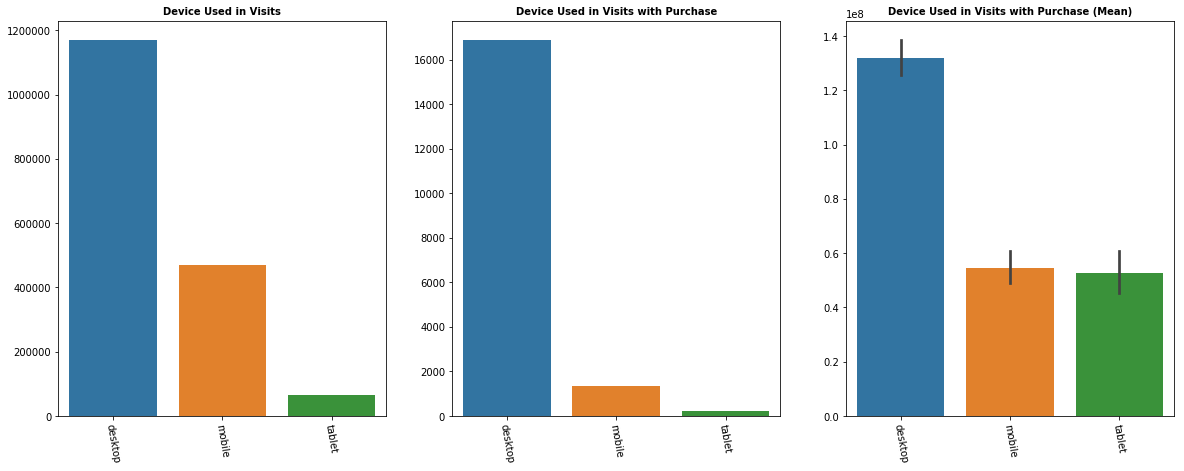

In [7]:
plt.figure(figsize=[20,16])

def create_countplot(column, title, plt_n, df=train, mean_ch = False):
    labels = list(df[column].value_counts().index.unique())

    fontdict = {'fontsize': 10, 'fontweight' : 'bold'}
    plt.subplot(plt_n)
    if mean_ch:
        sns.barplot(x = column, y="totals.transactionRevenue", data=df, order = labels[:10])
    else:
        sns.countplot(x = column, data=df, order = labels[:10])
    plt.xticks(np.arange(0, len(labels[:10]), 1), labels, rotation=-80)
    plt.title(title, fontdict=fontdict)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.xlabel('')
    plt.ylabel('')
    
create_countplot( 'device.deviceCategory', 'Device Used in Visits', 231)
create_countplot( 'device.deviceCategory', 'Device Used in Visits with Purchase', 232, train.loc[train["totals.transactionRevenue"] > 0])
create_countplot( 'device.deviceCategory', 'Device Used in Visits with Purchase (Mean)', 233, train.loc[train["totals.transactionRevenue"] > 0], True)

## Device Category: What We Learned

- Most visits are from a desktop computer, next mobile phones and very few from tablets.

- Desktop visits are also more likely to make a purchase and spend more when they do. This intuitively makes sense, as most people use their phones on the go and are more likely to be casually browsing perhaps even saving purchases for when they are at a computer.

- While mobile visitor are more common, mobile and tablet visitors seem to have similar behavior. 


# Device Browser: Exploration

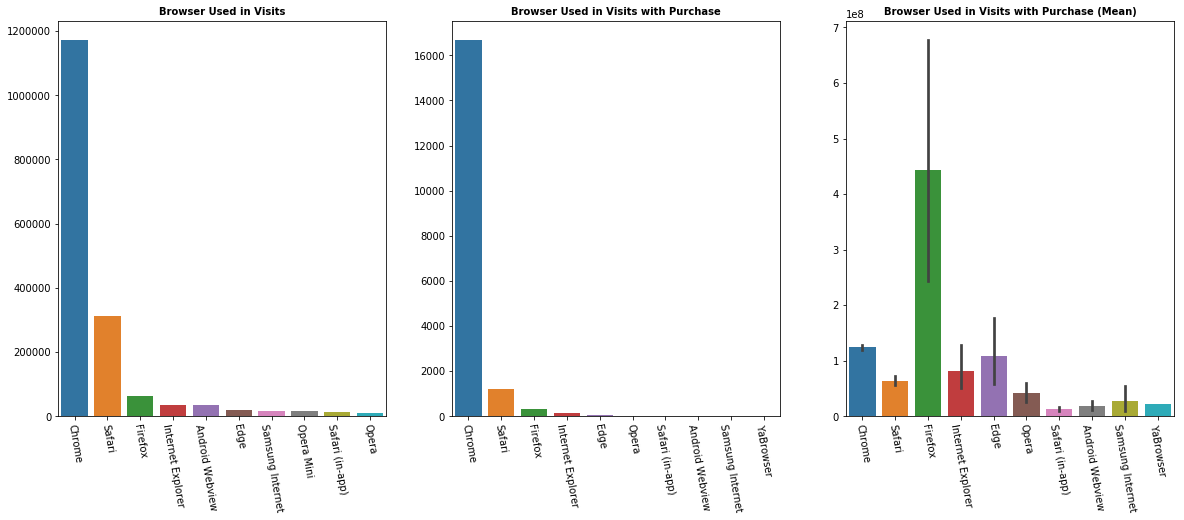

In [8]:
plt.figure(figsize=[20,16])

create_countplot( 'device.browser', 'Browser Used in Visits', 231)
create_countplot( 'device.browser', 'Browser Used in Visits with Purchase', 232, train.loc[train["totals.transactionRevenue"] > 0])
create_countplot( 'device.browser', 'Browser Used in Visits with Purchase (Mean)', 233, train.loc[train["totals.transactionRevenue"] > 0], True)

## Device Browser: What We Learned

- Most visits and visits with purchase are from Chrome browser. Makes sense as Chrome is a Google product and users are probably more likely to be Google fans.

- Firefox seems to have larger purchases. However, the confidence is very low due to the small sample of Firefox purchases so this could very well be a fluke. Other than that, Chrome is confidently higher than the others besides Firefox.

# Opperating System: Exploration

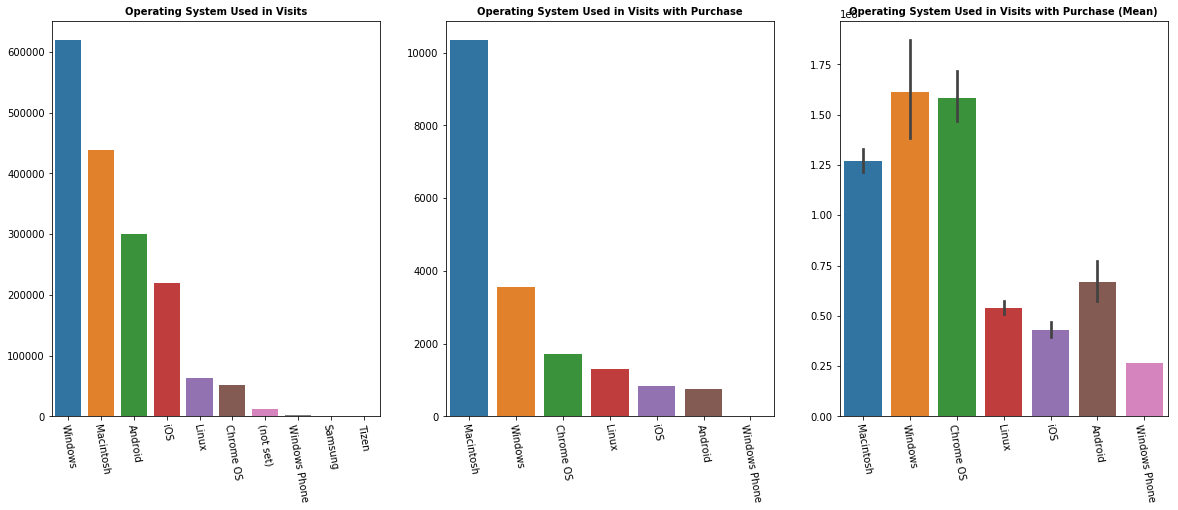

In [9]:
plt.figure(figsize=[20,16])

create_countplot( 'device.operatingSystem', 'Operating System Used in Visits', 231)
create_countplot( 'device.operatingSystem', 'Operating System Used in Visits with Purchase', 232, train.loc[train["totals.transactionRevenue"] > 0])
create_countplot( 'device.operatingSystem', 'Operating System Used in Visits with Purchase (Mean)', 233, train.loc[train["totals.transactionRevenue"] > 0], True)

## Opperating System: What We Learned

- Windows is the most common operating system used to visit. In fact, the operating system used seems to just follow the most common models.

- Despite this, Macintosh users were much much more likely than windows users in visits with purchase. Perhaps because Macintosh users tend to be considered more "tech savvy" and may have more interest in tech based swag.

- Chrome OS, despite it rarity, is more likely to purchase something which makes sense since it is made by google.

- Mobile operating systems tend to purchase less often and spend less when they do. This is consistent with the hypothesis that visitor tend to commit to purchase more at a desktop computer than on their phones.


# Network Domains: Exploration

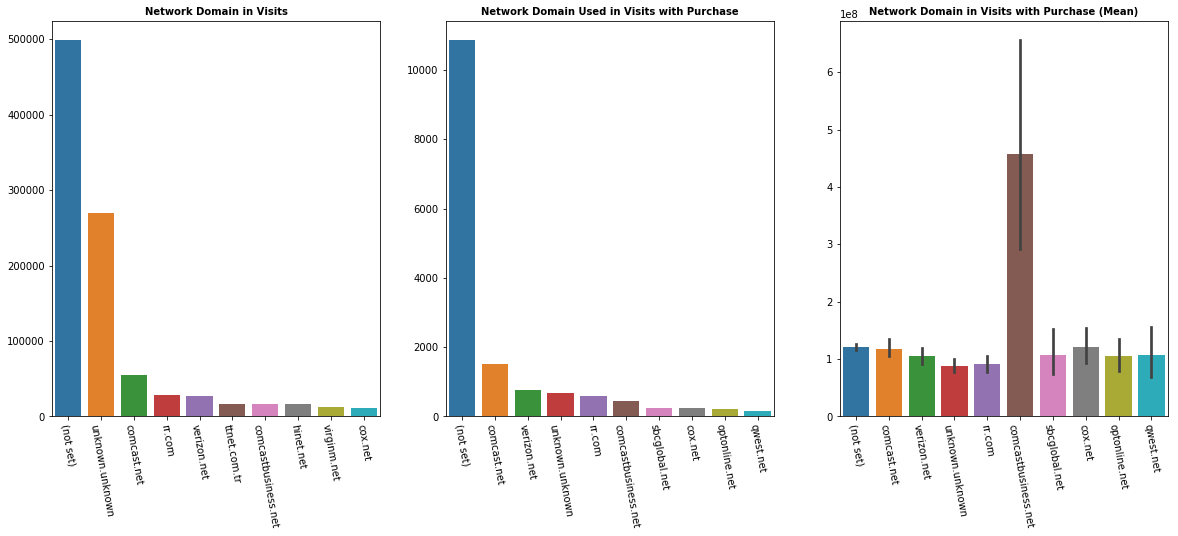

In [10]:
plt.figure(figsize=[20,16])

create_countplot( 'geoNetwork.networkDomain', 'Network Domain in Visits', 231)
create_countplot( 'geoNetwork.networkDomain', 'Network Domain Used in Visits with Purchase', 232, train.loc[train["totals.transactionRevenue"] > 0])
create_countplot( 'geoNetwork.networkDomain', 'Network Domain in Visits with Purchase (Mean)', 233, train.loc[train["totals.transactionRevenue"] > 0], True)

## Network Domains: What We Learned

- Most network domains are (not set) or unknown.unknown. Unfortunately, this means that we cannot get much useful information from this from a simple EDA. A careful machine learning model might still make use of this column.

- The one small bit of information we can see is that comcastbusiness.net has much higher mean purchases than the other network domains. The subsample size is small but, even with the low confidence, the difference is still large enough to say that this is probably true.


# Continent: Exploration

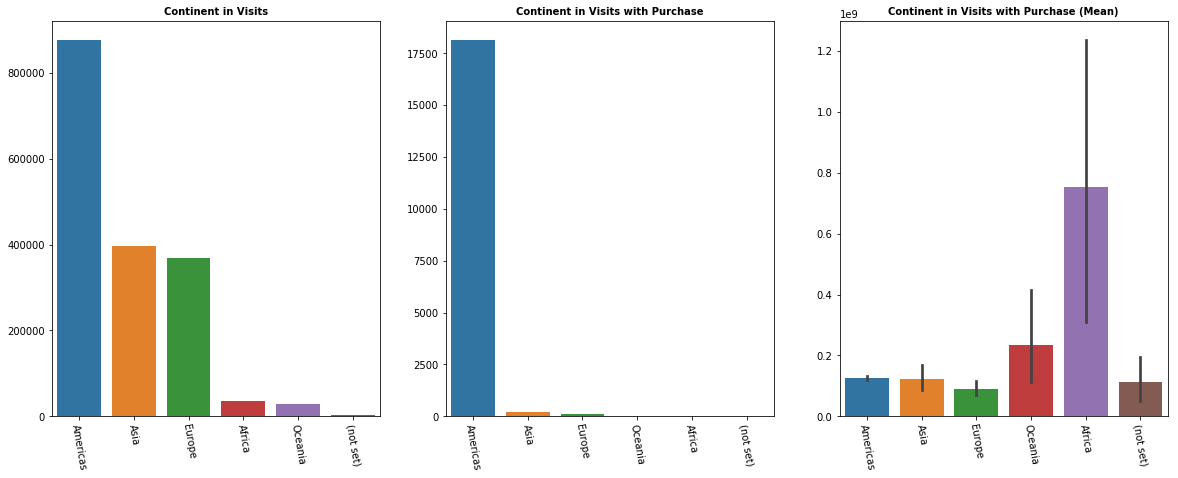

In [11]:
plt.figure(figsize=[20,16])

create_countplot( 'geoNetwork.continent', 'Continent in Visits', 231)
create_countplot( 'geoNetwork.continent', 'Continent in Visits with Purchase', 232, train.loc[train["totals.transactionRevenue"] > 0])
create_countplot( 'geoNetwork.continent', 'Continent in Visits with Purchase (Mean)', 233, train.loc[train["totals.transactionRevenue"] > 0], True)

## Continent: What We Learned

- Americas are the most likely visitors and overwhelmingly the most likely to make a purchase. In fact, almost every purchase was made in the Americas.

- Despite the abnormal spike in africa mean purchase, that comparison is unusable due to the small subsample sizes of non-Americas purchases.


# Sub Continent: Exploration

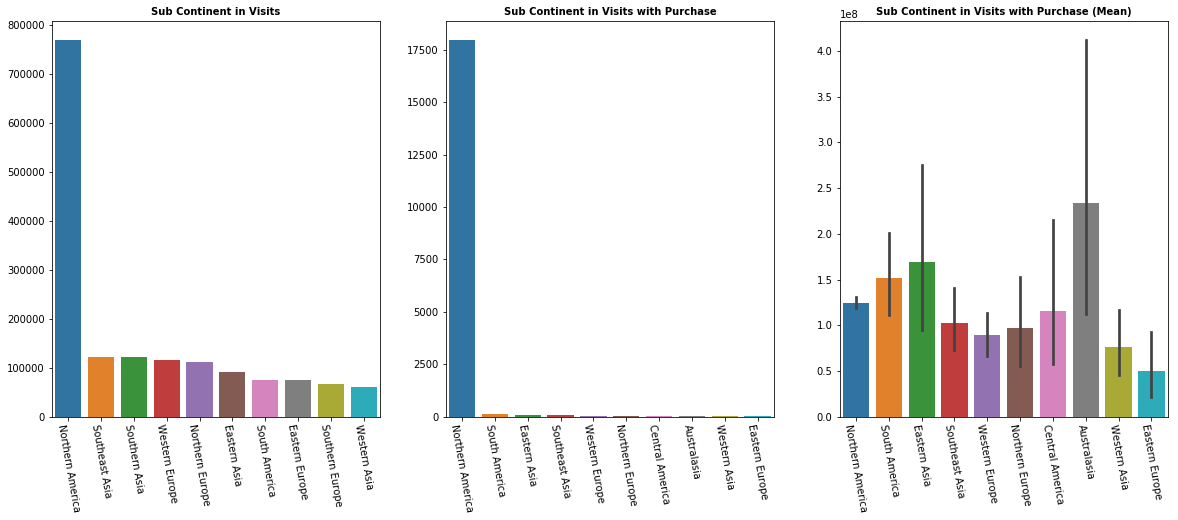

In [12]:
plt.figure(figsize=[20,16])

create_countplot( 'geoNetwork.subContinent', 'Sub Continent in Visits', 231)
create_countplot( 'geoNetwork.subContinent', 'Sub Continent in Visits with Purchase', 232, train.loc[train["totals.transactionRevenue"] > 0])
create_countplot( 'geoNetwork.subContinent', 'Sub Continent in Visits with Purchase (Mean)', 233, train.loc[train["totals.transactionRevenue"] > 0], True)

## Sub Continent: What We Learned

- These charts parrots the results of the last ones, but narrows down the area to just Northern America. Unsurprisingly, purchases in South America are about as insignificant as all other non-North America sub continents.

# Traffic Source: Exploration

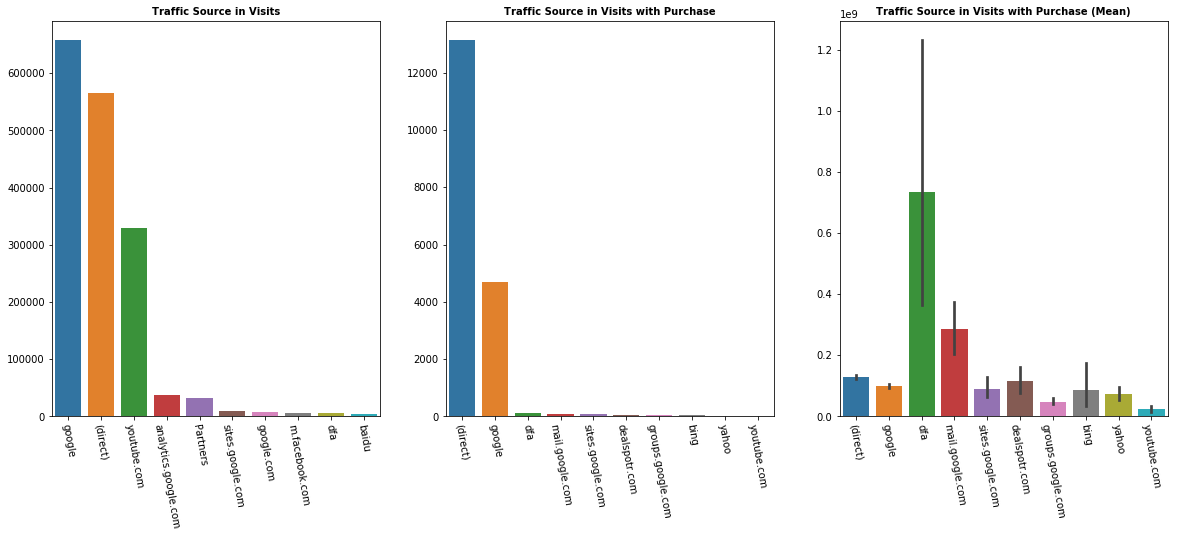

In [13]:
plt.figure(figsize=[20,16])

create_countplot( 'trafficSource.source', 'Traffic Source in Visits', 231)
create_countplot( 'trafficSource.source', 'Traffic Source in Visits with Purchase', 232, train.loc[train["totals.transactionRevenue"] > 0])
create_countplot( 'trafficSource.source', 'Traffic Source in Visits with Purchase (Mean)', 233, train.loc[train["totals.transactionRevenue"] > 0], True)

## Traffic Source: What We Learned

- Most visitors come from google, youtube.com, or a direct link.

- visitors that followed a direct link were way more likely to make a purchase. In contrast, those that came from google were likely just browsing.

- Surprisingly, despite a large portion of overall visitors coming by way of youtube.com, almost none of them made a purchase.


# Traffic Medium: Exploration

In [ ]:
train.loc[train['trafficSource.medium'] == '(none)']['trafficSource.source'].sum()

In [ ]:
plt.figure(figsize=[20,16])

create_countplot( 'trafficSource.medium', 'Traffic Medium in Visits', 231)
create_countplot( 'trafficSource.medium', 'Traffic Medium in Visits with Purchase', 232, train.loc[train["totals.transactionRevenue"] > 0])
create_countplot( 'trafficSource.medium', 'Traffic Medium in Visits with Purchase (Mean)', 233, train.loc[train["totals.transactionRevenue"] > 0], True)

## Traffic Medium: What We Learned

- Unsurprisingly, organic traffic is very high. Since this traffic typically comes from search engines and Google owns the most popular one. 

- The high number of referral visits suggests social media success. Agian not that surpising considering Googles strong brand.

- The cpm (cost per thousand) to cpc (cost per click) ads might be a good place to check relative success

# Date and Time: Explorations

In [ ]:
def time_stamp_features(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["weekday"] = df['date'].dt.weekday #extracting week day
    df["day"] = df['date'].dt.day # extracting day
    df["month"] = df['date'].dt.month # extracting day
    df["year"] = df['date'].dt.year # extracting day
    df["hour"] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    return df
time_train = time_stamp_features(train)
p_time_train = time_train.loc[time_train["totals.transactionRevenue"] > 0]

def create_timeplot(var, title, xlabel, ylabel, labels = []):
    plt.figure(figsize=[40,16])
    
    df_count = time_train[var].value_counts().to_frame().reset_index().sort_values('index') 
    df_sum = df_count[var].sum()

    sns.lineplot(x = "index", y = var, data = df_count, estimator=lambda x: x / df_sum * 100, label="%Visits")

    df_count = p_time_train[var].value_counts().to_frame().reset_index().sort_values('index')
    df_sum = df_count[var].sum()

    sns.lineplot(x = "index", y = var, data = df_count, color="Orange", estimator=lambda x: x / df_sum * 100, label="%Visits with Purchase")

    fontdict = {'fontsize': 40, 'fontweight' : 'bold'}

    plt.title(title, fontdict=fontdict)
    plt.tick_params(axis='both', which='major', labelsize=30)
    if labels != []:
        plt.xticks(np.arange(0, len(labels), 1), labels)
    plt.xlabel(xlabel, fontdict=fontdict)
    plt.ylabel(ylabel, fontdict=fontdict)
    plt.legend(fontsize=30)
    plt.show()

# Hour of the Day: Exploration

In [ ]:
create_timeplot("hour","Visits by Hour of the Day","Hour of the Day", "% of Visits")

## Hour of the Day: What We Learned

- Even though people visit the site from all over the world, there is a clear difference in visit at different times during the day. This is likely because the vast majority of visits and purchases are from america and the more active hours for the site are during the afternoon-night in america.

- While both lines follow the same trend, the visits with purchase line is much more pronounced. Noting again that these lines follow american time zones, we can also infer that while people might still visit the site different hours of the day, few people seem less inclined to make purchases during late night/early morning hours and are more likely to actually pull out their credit cards and make a purchase in the evening.


# Date: Exploration

In [ ]:
create_timeplot("date","Visits by Date","Date", "% of Visits")

# Date: What We Learned

- The data has very clear regular waves for both Visits and Visits with Purchase. This is likely due to regular weekly tendencies in visitor behavior.

- There are 2 anomalous spikes in the data: a blue one at the end of 2017 and an orange one around 2018-04. This is probably just noise since they are short blips unless there was some event, like a one day sale, that might have triggered them.


# Weekday: Exploration

In [ ]:
create_timeplot("weekday","Visits by Weekday","Weekday", "% of Visits", ["Monday","Tuesday","Wendsday", "Thursday", "Friday", "Saturday", "Sunday"])

## Weekday: What We Learned

- There are more visits and purchases on the site during weekdays and less on the weekends. This explains the wavey data in the visits by date chart.

# Page Views and Hits: Exploration

In [ ]:
train['totals.pageviews'] = train['totals.pageviews'].astype("float")
train['totals.hits'] = train['totals.hits'].astype("float")

plt.figure(figsize=[20,16])
def create_viewplot(column, title, plt_n, df=train, mean_ch = False):
    df = df.loc[df[column] <= 60].sort_values(column) 
    labels = np.arange(0, 60, step=5)
    fontdict = {'fontsize': 10, 'fontweight' : 'bold'}
    plt.subplot(plt_n)
    if mean_ch:
        sns.barplot(x = column, y="totals.transactionRevenue", data=df)
    else:
        sns.countplot(x = column, data=df)
    plt.xticks(np.arange(-1, 60, step=5),labels, rotation=-80)
    plt.title(title, fontdict=fontdict)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.xlabel('')
    plt.ylabel('')

create_viewplot( 'totals.pageviews', '# of Page Views in Visit', 231)
create_viewplot( 'totals.pageviews', '# of Page Views in Visit with Purchase', 232, train.loc[train["totals.transactionRevenue"] > 0])
create_viewplot( 'totals.pageviews', '# of Page Views in Visit with Purchase (Mean)', 233, train.loc[train["totals.transactionRevenue"] > 0], True)

create_viewplot( 'totals.hits', '# of hits in Visit', 234)
create_viewplot( 'totals.hits', '# of hits in Visit with Purchase', 235, train.loc[train["totals.transactionRevenue"] > 0])
create_viewplot( 'totals.hits', '# of hits in Visit with Purchase (Mean)', 236, train.loc[train["totals.transactionRevenue"] > 0], True)

plt.show()

## Weekday: What We Learned

- The Page Views and Hits charts are all very similar and there are no real notable differences. This is likely because they are so strongly correlated with each other and only have slightly different meanings.

- Purchase visits max around 15-20 page view/hits and follow a right-skewed distribution.

- While the means revenue graphs have some spikes throughout the charts, the low confidence rates and scattered occurrences suggest that this is likely just from small subsample sizes. 

- That being said, there might still be some evidence that single page/hit visitors make larger purchases, on the rare chance that they do, since both means graphs show rather large spikes at 1 visit hits. This *might* be true because they might have been following direct links to the site and already had their purchase in mind with no interest in browsing.


# "Conculsion"

(Data visialzations and analysis notebooks often don't have or need an overall conculsion, but maybe we could add one anyways if we want to)